# Определение типа воды по качеству

In [1]:
# импорт необходимых библиотек
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import xgboost as xgb
from xgboost import plot_importance
import catboost as cb
from hyperopt import hp, fmin, tpe, Trials
import seaborn as sns
import matplotlib.pyplot as plt
import pickle

In [2]:
df = pd.read_csv('Downloads/Drinking_water.csv')
df

/var/folders/1b/k9jr1c9576n77p09jjgpyf980000gn/T/ipykernel_26163/410655265.py:1: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('Downloads/Drinking_water.csv')


,Sample Number,Sample Date,Sample Time,Sample Site,Sample class,Residual Free Chlorine (mg/L),Turbidity (NTU),Fluoride (mg/L),Coliform (Quanti-Tray) (MPN /100mL),E.coli(Quanti-Tray) (MPN/100mL)
0,202120243,07/01/2021,10:31,23650,Compliance,0.22,0.84,NaN,<1,<1
1,202120244,07/01/2021,09:54,29550,Compliance,0.69,0.81,NaN,<1,<1
2,202120245,07/01/2021,07:52,50200,Operational,0.55,0.77,NaN,<1,<1
3,202120246,07/01/2021,08:12,50250,Compliance,0.87,0.81,NaN,<1,<1
4,202120247,07/01/2021,08:31,50300,Operational,0.80,0.84,NaN,<1,<1
...,...,...,...,...,...,...,...,...,...,...
136430,202329514,11/13/2023,1899-12-31T09:27:00.000,37950,Compliance,NaN,NaN,NaN,NaN,NaN
136431,202329520,11/13/2023,1899-12-31T09:54:00.000,38250,Compliance,NaN,NaN,NaN,NaN,NaN
136432,202329515,11/13/2023,1899-12-31T08:35:00.000,39650,Compliance,NaN,NaN,NaN,NaN,NaN
136433,202329559,11/13/2023,1899-12-31T08:55:00.000,3SC26,Operational,0.84,0.76,NaN,<1,<1


## Предобработка данных

In [3]:
# Удаляю лишние строки
new_df = df.drop(['Sample Number', 'Sample Date', 'Sample Time', 'Sample Site'], axis=1)

In [4]:
new_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 136435 entries, 0 to 136434
Data columns (total 6 columns):
 #   Column                               Non-Null Count   Dtype  
---  ------                               --------------   -----  
 0   Sample class                         136435 non-null  object 
 1   Residual Free Chlorine (mg/L)        136405 non-null  float64
 2   Turbidity (NTU)                      136403 non-null  object 
 3   Fluoride (mg/L)                      17972 non-null   object 
 4   Coliform (Quanti-Tray) (MPN /100mL)  136340 non-null  object 
 5   E.coli(Quanti-Tray) (MPN/100mL)      136340 non-null  object 
dtypes: float64(1), object(5)
memory usage: 6.2+ MB


In [5]:
# Функция для удаления знаков '<>'
def clean_column_values(value):
    if isinstance(value, str):
        value = value.replace('<', '').replace('>', '')
    return float(value) if value else None

# Удаляю знаки '<>'
columns_to_clean = ['Turbidity (NTU)', 'Fluoride (mg/L)', 'Coliform (Quanti-Tray) (MPN /100mL)', 'E.coli(Quanti-Tray) (MPN/100mL)']
new_df[columns_to_clean] = new_df[columns_to_clean].applymap(clean_column_values)

/var/folders/1b/k9jr1c9576n77p09jjgpyf980000gn/T/ipykernel_26163/259687332.py:9: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  new_df[columns_to_clean] = new_df[columns_to_clean].applymap(clean_column_values)


In [6]:
new_df['Sample class'].describe()

count         136435
unique             5
top       Compliance
freq           84897
Name: Sample class, dtype: object

In [7]:
new_df.describe()

,Residual Free Chlorine (mg/L),Turbidity (NTU),Fluoride (mg/L),Coliform (Quanti-Tray) (MPN /100mL),E.coli(Quanti-Tray) (MPN/100mL)
count,136405.000000,136403.000000,17972.000000,136340.000000,136340.000000
mean,0.565828,0.724905,0.708604,1.128623,0.999934
std,0.215760,0.260259,0.057052,4.526426,0.027218
min,-9.990000,0.100000,0.030000,-9.000000,-9.000000
25%,0.430000,0.620000,0.690000,1.000000,1.000000
50%,0.580000,0.730000,0.710000,1.000000,1.000000
75%,0.710000,0.840000,0.730000,1.000000,1.000000
max,2.200000,33.800000,0.890000,200.500000,2.000000


In [8]:
values = {
    'Residual Free Chlorine (mg/L)': new_df['Residual Free Chlorine (mg/L)'].median(),
    'Turbidity (NTU)': new_df['Turbidity (NTU)'].median(),
    'Fluoride (mg/L)': new_df['Fluoride (mg/L)'].median(),
    'Coliform (Quanti-Tray) (MPN /100mL)': new_df['Coliform (Quanti-Tray) (MPN /100mL)'].median(),
    'E.coli(Quanti-Tray) (MPN/100mL)': new_df['E.coli(Quanti-Tray) (MPN/100mL)'].median()
}
#заполняем пропуски в соответствии с заявленным словарем
new_df = new_df.fillna(values)
#выводим результирующую долю пропусков
new_df.isnull().mean()

Sample class                           0.0
Residual Free Chlorine (mg/L)          0.0
Turbidity (NTU)                        0.0
Fluoride (mg/L)                        0.0
Coliform (Quanti-Tray) (MPN /100mL)    0.0
E.coli(Quanti-Tray) (MPN/100mL)        0.0
dtype: float64

In [9]:
new_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 136435 entries, 0 to 136434
Data columns (total 6 columns):
 #   Column                               Non-Null Count   Dtype  
---  ------                               --------------   -----  
 0   Sample class                         136435 non-null  object 
 1   Residual Free Chlorine (mg/L)        136435 non-null  float64
 2   Turbidity (NTU)                      136435 non-null  float64
 3   Fluoride (mg/L)                      136435 non-null  float64
 4   Coliform (Quanti-Tray) (MPN /100mL)  136435 non-null  float64
 5   E.coli(Quanti-Tray) (MPN/100mL)      136435 non-null  float64
dtypes: float64(5), object(1)
memory usage: 6.2+ MB


**Все пропуски заполнены и значения приведены к float**

## XGBoost

In [10]:
X = new_df.drop(['Sample class'], axis=1)
y = new_df['Sample class']
# Целевая переменная для модели XGBoost должна быть представлена целым числом.
y = new_df['Sample class'].apply(lambda x: 0 if x == "Compliance" else 
                                           1 if x == "Operational" else 
                                           2 if x == "Resample_Compliance" else 
                                           3 if x == "Resample_Operational" else 
                                           4 if x == "Op-resample" else 
                                           5)

In [11]:
# разделение выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [12]:
# Инициализация экзмепляра класса XGBClassifier
xgb_classifier = xgb.XGBClassifier()

In [13]:
# Определение сетки параметров для перебора.
parameters = {
    'max_depth': [3, 5, 7, 9],
    'learning_rate': [0.2, 0.1, 0.01, 0.001],
    'n_estimators': [20, 30, 50, 100]
}

In [14]:
# Инициализация экзмепляра класса GridSearchCV
grid_search = GridSearchCV(estimator=xgb_classifier,  param_grid=parameters,  scoring='accuracy', cv=5)

In [15]:
# Обучение модели с перебором параметров
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=None, ...),
             param_grid={'learning_rate': [0.2, 0.1, 0.01, 0.001],
                         'max_depth': [3, 5, 7, 9],
                         'n_estimators': [20, 30, 50, 100]},
             scoring='accuracy')

In [16]:
# Лучшие параметры и точность модели
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Лучшие параметры:", best_params)
print("Точность на обучающем наборе:", best_score)

# Оценка модели на тестовом наборе
y_pred = grid_search.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Точность на тестовом наборе:", accuracy)

Лучшие параметры: {'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 100}
Точность на обучающем наборе: 0.7445670446381987
Точность на тестовом наборе: 0.7467658592003518


**Важность признаков (Feature Importance)**

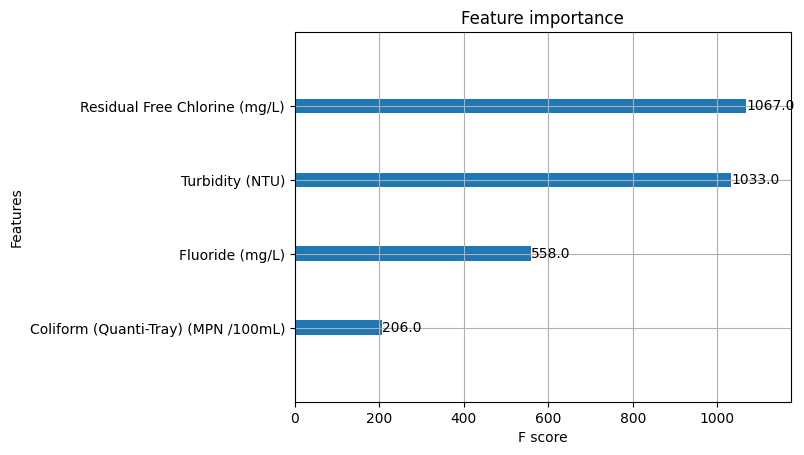

In [17]:
best_xg_model = grid_search.best_estimator_

plot_importance(best_xg_model)
plt.show()

**Матрица ошибок (Confusion matrix)**

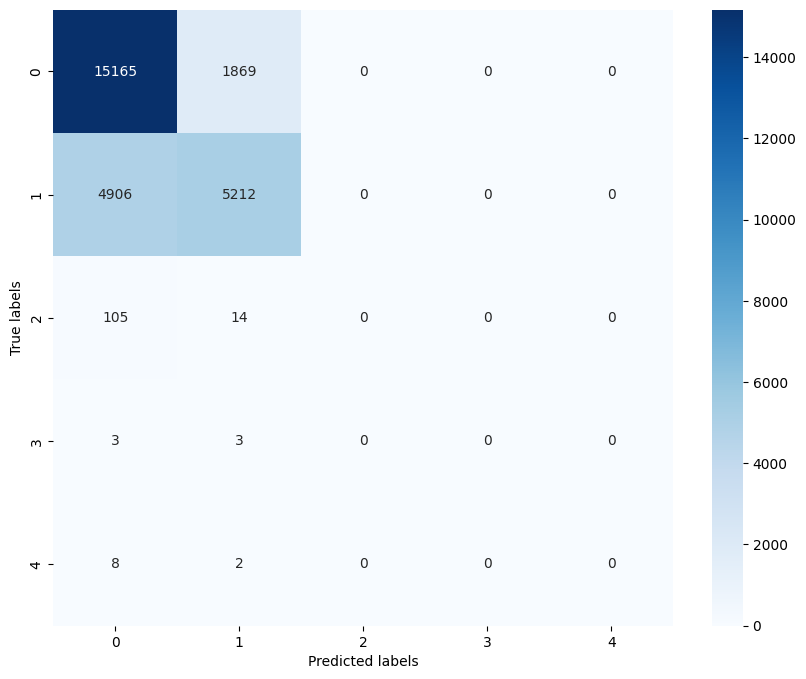

In [18]:
# Вычисление матрицы ошибок
cm = confusion_matrix(y_test, y_pred)

# Визуализация матрицы ошибок
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt=".0f", cmap="Blues")
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.show()

## Catboost

In [19]:
X = new_df.drop(['Sample class'], axis=1)
y = new_df['Sample class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [20]:
dict_of_params = {
    'iterations': [30, 50, 70],
    'depth': [3, 5, 7],
    'learning_rate': [0.01, 0.3],
    'l2_leaf_reg': [1, 3, 5, 7, 9]
}

In [21]:
# Переводим словарь dict_of_params в формат Hyperopt
space = {
    'iterations': hp.choice('iterations', dict_of_params["iterations"]),
    'depth': hp.choice('depth', dict_of_params["depth"]),
    'learning_rate': hp.uniform('learning_rate', dict_of_params["learning_rate"][0], dict_of_params["learning_rate"][1]),
    'l2_leaf_reg': hp.choice('l2_leaf_reg', dict_of_params["l2_leaf_reg"])
}

In [22]:
# Определяем функцию для оптимизации с гиперпараметрами
def objective(params):
    model = cb.CatBoostClassifier(**params)
    model.fit(X_train, y_train, silent=True)
    y_pred = model.predict(X_test)
    score = accuracy_score(y_test, y_pred)
    return score

In [23]:
# Запускаем оптимизацию с помощью Hyperopt
trials = Trials()
best = fmin(objective, space, algo=tpe.suggest, max_evals=100, trials=trials)

100%|███████| 100/100 [01:43<00:00,  1.03s/trial, best loss: 0.7367244475391211]


In [24]:
# Получаем лучшие значения гиперпараметров
final_best_params = {}
for key in best:
    try:
        final_best_params[key] = dict_of_params[key][best[key]]
    except:
        final_best_params[key] = best[key]


# Обучаем модель с лучшими гиперпараметрами
# Создание экземпляра CatBoostClassifier
model = cb.CatBoostClassifier(**final_best_params)
model.fit(X_train, y_train, silent=True)


# Предсказываем классы для тестовых данных
y_pred = model.predict(X_test)

# Вычисляем точность модели
accuracy = accuracy_score(y_test, y_pred)

# Выводим результаты
print("Точность модели:", accuracy)

Точность модели: 0.7367244475391211


**Важность признаков (Feature Importance)**

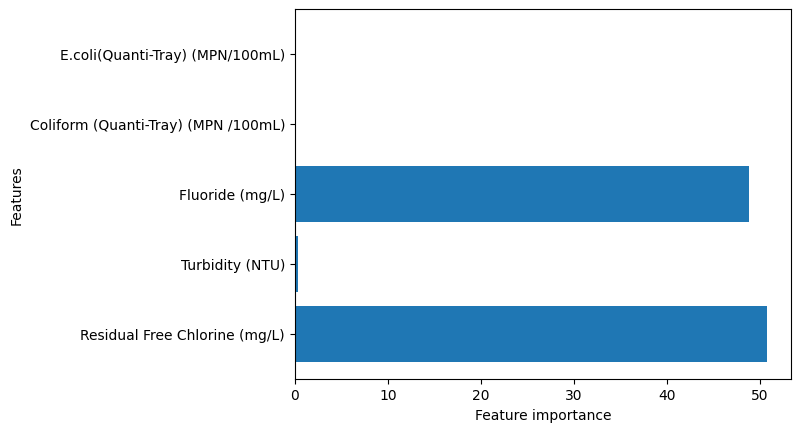

In [25]:
feature_importance = model.get_feature_importance()
feature_names = model.feature_names_

plt.barh(feature_names, feature_importance)
plt.xlabel('Feature importance')
plt.ylabel('Features')
plt.show()

## BaggingClassifier

In [26]:
# Разделение набора данных на признаки и целевую переменную
X = new_df.drop(['Sample class'], axis=1)
y = new_df['Sample class']

In [27]:
# Разделение набора данных на обучающий и тестовый наборы
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [28]:
#Определение гиперпараматров и создание модели
bagging_water_quality = BaggingClassifier(estimator = DecisionTreeClassifier(), n_estimators = 20, random_state = 0)

In [29]:
# Обучение бэггинг-регрессора на обучающем наборе
bagging_water_quality.fit(X_train, y_train)

BaggingClassifier(estimator=DecisionTreeClassifier(), n_estimators=20,
                  random_state=0)

In [30]:
# Оценка модели на тестовом наборе
y_pred = bagging_water_quality.predict(X_test)
accuracy_bagging_water_quality = accuracy_score(y_test, y_pred)
print(accuracy_bagging_water_quality)

0.7278191080001466


## LogisticRegression

In [31]:
# Разделение набора данных на признаки и целевую переменную
X = new_df.drop(['Sample class'], axis=1)
y = new_df['Sample class']

In [32]:
# Cоздание модели
logistic_regression_water_quality = LogisticRegression(multi_class = 'multinomial', solver = 'lbfgs', max_iter = 1000)

In [33]:
# Обучение модели на обучающем наборе
logistic_regression_water_quality.fit(X_train, y_train)

LogisticRegression(max_iter=1000, multi_class='multinomial')

In [34]:
# Оценка модели на тестовом наборе
y_pred = logistic_regression_water_quality.predict(X_test)
accuracy_logistic_regression_water_quality = accuracy_score(y_test, y_pred)
print(accuracy_logistic_regression_water_quality)

0.7068200974823176


# Наилучший результат показала модель XGBoost

## XGBoost - 0.75
#### CatBoost - 0.74
#### BaggingClassifier - 0.73
#### LogisticRegression - 0.71

# Сохранение обученной модели XGBoost

In [ ]:
# сохраняем модель в заданный файл
filename = 'grid_xgboost_params.sav'
pickle.dump(grid_search, open(filename, 'wb'))

In [ ]:
# можно прочитать модель из файла и убедиться, что сохранение прошло успешно (параметры модели остались неизменными)
model = pickle.load(open('grid_xgboost_params.sav', 'rb'))
print(model.best_params_)

{'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 100}
